In [1]:
import warnings
warnings.filterwarnings('ignore')

from collections import Counter
from scipy.stats import norm
from scipy import misc
from mpl_toolkits.mplot3d import Axes3D
from keras import optimizers
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, r2_score
from keras.layers.pooling import MaxPooling2D, GlobalAveragePooling2D
import numpy as np
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
import cv2
import time
import glob
import sys
import scipy
sns.set(style="darkgrid", context="talk", palette="Set2")
RANDOM_STATE = 2401
np.random.seed(RANDOM_STATE)

%matplotlib inline

Using TensorFlow backend.


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
images = []
label = []
folders = ["../content/drive/My Drive/Colab Notebooks/train/fried_rice", "../content/drive/My Drive/Colab Notebooks/train/ramen"]
for folder in folders:
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder,filename))
        img = cv2.resize(img,(128,128))
        if img is not None:
            images.append(img)
            label.append(folder.split("/")[-1])

In [0]:
X_train = np.asarray(images)
label = [1 if name == "fried_rice" else 0 for name in label]
Y_train = np.asarray(label)

In [0]:
images = []
ids = []
folders = ["../content/drive/My Drive/Colab Notebooks/test"]
for folder in folders:
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder,filename))
        img = cv2.resize(img,(128,128))
        if img is not None:
            images.append(img)
            ids.append(filename)

In [0]:
x_test = np.asarray(images)

In [0]:
from keras.applications.xception import Xception
 
application = Xception(include_top=False, weights='imagenet', input_shape=(128, 128, 3))

In [0]:
X_train.shape

(1600, 128, 128, 3)

In [0]:
img_rows, img_cols = 128, 128

batch_size = 25
num_classes = 2
epochs = 5

x_train, x_val, y_train, y_val = train_test_split(X_train,Y_train,test_size=0.25,random_state=RANDOM_STATE)

if K.image_dim_ordering() == 'th':
    x_train = x_train.reshape(x_train.shape[0], 3, img_rows, img_cols)
    x_val = x_val.reshape(x_val.shape[0], 3, img_rows, img_cols)
    input_shape = (3, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 3)
    x_val = x_val.reshape(x_val.shape[0], img_rows, img_cols, 3)
    input_shape = (img_rows, img_cols, 3)
    
x_train = x_train.astype('float32')
x_train = x_train/255.0
x_val = x_val.astype('float32')
x_val = x_val/255.0

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_val.shape[0], 'test samples')

y_train = keras.utils.to_categorical(y_train, num_classes)
y_val = keras.utils.to_categorical(y_val, num_classes)

x_train shape: (1200, 128, 128, 3)
1200 train samples
400 test samples


In [0]:
y_train

array([[1., 0.],
       [0., 1.],
       [0., 1.],
       ...,
       [0., 1.],
       [1., 0.],
       [0., 1.]], dtype=float32)

In [0]:
from keras import models
from keras import layers
from keras import optimizers
 
# Create the model
model = models.Sequential()
 
# Add the vgg convolutional base model
model.add(application)
 
# Add new layers
model.add(layers.Flatten())
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(2, activation='softmax'))
 
# Show a summary of the model. Check the number of trainable parameters
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Model)             (None, 4, 4, 2048)        20861480  
_________________________________________________________________
flatten_1 (Flatten)          (None, 32768)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              33555456  
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 2050      
Total params: 54,418,986
Trainable params: 54,364,458
Non-trainable params: 54,528
_________________________________________________________________


In [0]:
model.compile(loss='categorical_crossentropy',optimizer=optimizers.Adam(),metrics=['acc'])
# Train the model
hist = model.fit(x_train, y_train,batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(x_val, y_val))
# Save the model
model.save('cobacoba.h5')

Train on 1200 samples, validate on 400 samples
Epoch 1/5
1200/1200 [==============================] - 695s 580ms/step - loss: 0.6329 - acc: 0.7583 - val_loss: 2.5975 - val_acc: 0.7825
Epoch 2/5
1200/1200 [==============================] - 684s 570ms/step - loss: 0.4397 - acc: 0.7825 - val_loss: 6.4624 - val_acc: 0.5275
Epoch 3/5
1200/1200 [==============================] - 671s 559ms/step - loss: 0.3005 - acc: 0.8542 - val_loss: 0.5739 - val_acc: 0.8925
Epoch 4/5
1200/1200 [==============================] - 689s 574ms/step - loss: 0.2224 - acc: 0.9142 - val_loss: 1.0727 - val_acc: 0.6675
Epoch 5/5
1200/1200 [==============================] - 682s 569ms/step - loss: 0.1286 - acc: 0.9458 - val_loss: 0.2073 - val_acc: 0.9375


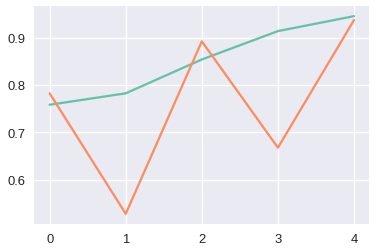

In [0]:
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.show()

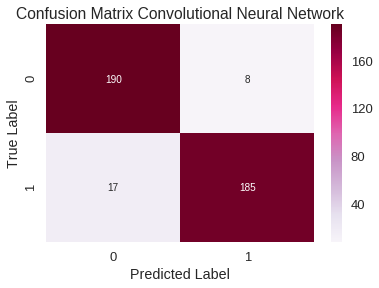

In [0]:
y_pred = model.predict_classes(x_val)
cm = confusion_matrix(np.argmax(y_val,axis=1),y_pred)

ax = plt.axes()
sns.heatmap(cm, annot=True, fmt="d", cmap="PuRd") #-___-
ax.set_title('Confusion Matrix Convolutional Neural Network')
#ax.set_yticklabels(le.inverse_transform([1,0]))
#ax.set_xticklabels(le.inverse_transform([0,1]))
ax.set_ylabel('True Label')
ax.set_xlabel('Predicted Label')
plt.show()

In [0]:
x_test = x_test/255.0

In [0]:
y_pred_test = model.predict_classes(x_test)

df = pd.DataFrame(columns=['id','kelas'])
df['id'] = ids.copy()
df['kelas'] = y_pred_test.copy()

In [0]:
df.to_csv('0102516002.csv', sep=',', index=False)

In [0]:
!pip install -U -q PyDrive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
uploaded = drive.CreateFile({'title': '0102516002.csv'})
uploaded.SetContentFile('0102516002.csv')
uploaded.Upload()